In [79]:
#only arg
mix_layer = 0

from mlp_mixer import * 
import json

path = "./models/20220314-162951/"
path = "./models/20220401-122435/"
with open(path+'out_hyperparams.json') as json_file:
    params = json.load(json_file)

print(params)

image_width_height = params['image_width_and_height'] #da cambiare a seconda della dimensione dell'immagine
patch_dims = params['patch_width_and_height']
# variable_name = value #paper value
n_channels = params['hidden_dim_size (n_channels)'] #10 #512
num_layers = params['number_of_layers'] #3
mlp_dc_dimension = params['mlp_dc_dimension'] #8 #2048 # dc è la dimensione del channel mixing (l'ultimo mlp)
mlp_ds_dimension = params['mlp_ds_dimension'] #8 #256 # ds è la dimensione del token mixing (il primo)

model = MLP_mixer(img_h_w=image_width_height, patch_dim=patch_dims, n_channels=n_channels, num_mixers_layers=num_layers,
    hidden_dim_mlp_token=mlp_ds_dimension, hidden_dim_mlp_channel=mlp_dc_dimension)

#model.load_state_dict(torch.load(path+"final.pth"))
#model.load_state_dict(torch.load(path+"checkpoint_epch_.pth"))
model.load_state_dict(torch.load(path+"1finetune_checkpoint_epch_10.pth"))
model.eval()


{'dataset': '-', 'rand_augm_numops': 3, 'rand_augm_magnitude': 15, 'comment': 'added weight decay', 'train_size': 626, 'validation_size': 25, 'learning_rate': 0.001, 'epochs': 500, 'steps': 626, 'batch_size': 2048, 'mixup_alpha': -1, 'weight_decay': 0.1, 'image_width_and_height': 64, 'patch_width_and_height': 8, 'hidden_dim_size (n_channels)': 128, 'number_of_layers': 8, 'mlp_dc_dimension': 512, 'mlp_ds_dimension': 64}


MLP_mixer(
  (patch_embedder): Conv2d(3, 128, kernel_size=(8, 8), stride=(8, 8))
  (mixerlayers): ModuleList(
    (0): MixerLayer(
      (layer_norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (MLP1): MLP(
        (linear_gelu_stack): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): GELU()
          (2): Linear(in_features=64, out_features=64, bias=True)
        )
      )
      (MLP2): MLP(
        (linear_gelu_stack): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU()
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
      )
    )
    (1): MixerLayer(
      (layer_norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (MLP1): MLP(
        (linear_gelu_stack): Sequential(
          (0):

In [80]:
print(model.mixerlayers[0].MLP1.linear_gelu_stack[0])


Linear(in_features=64, out_features=64, bias=True)


In [81]:
import numpy as np
block0 = model.mixerlayers[mix_layer].MLP1.linear_gelu_stack[0].weight.detach().numpy()
block1 = model.mixerlayers[mix_layer].MLP1.linear_gelu_stack[2].weight.detach().numpy()

#block0 = model.mixerlayers[0].MLP1.linear_gelu_stack[0].weight.detach().numpy()
#block1 = model.mixerlayers[0].MLP1.linear_gelu_stack[2].weight.detach().numpy()

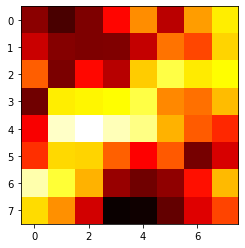

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ogni riga è una weight visualization
import math
width = int(math.sqrt(block0.shape[1]))
row = block0[mix_layer].reshape(width, width)
plt.imshow(row, cmap='hot', interpolation='nearest')
plt.show()

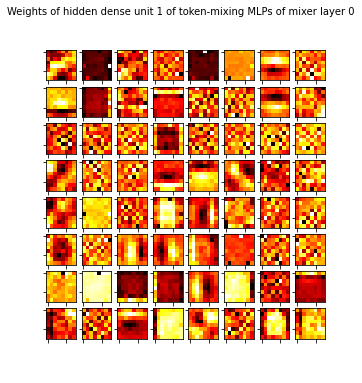

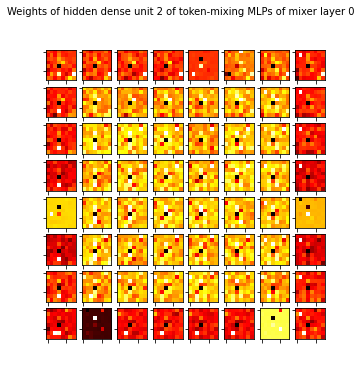

In [90]:
def plot_weights(block, elements_per_row = 16, num_b = num_block, mixer_layer = -1):
    #block = block0 #per block1, uguale facendo trasposizione, vogliamo block = (#hidden, tbd)
    #elements_per_row = 8 #quando ci sono tante hidden layers, da decidere quanti elementi visualizzare per ogni riga
    width = int(math.sqrt(block.shape[1]))
    #plt.figure(figsize=(10, 10))
    fig, axs = plt.subplots((block.shape[0] // elements_per_row)+1, elements_per_row, figsize=(5, 6))
    fig.suptitle(f'Weights of hidden dense unit {num_b} of token-mixing MLPs of mixer layer {mixer_layer}', fontsize=10)
    

    for row in axs:
        for col in row: 
            col.set_axis_off()
    #axs[1,1].set_axis_off()

    row_index = -1
    for i in range(block.shape[0]):
        if i % elements_per_row == 0:
            row_index += 1
        row = block[i].reshape(width, width)
        ax = axs[row_index, i%elements_per_row]
        ax.imshow(row, cmap='hot', interpolation='nearest', aspect = 'auto')
        ax.set_axis_on()
        ax.set_yticklabels([])
        ax.set_xticklabels([])


plot_weights(block0, 8, num_b=1, mixer_layer=mix_layer)
plot_weights(block1, 8, num_b=2, mixer_layer=mix_layer)